
Step 1: Loading CSV files with sampling to avoid memory issues...
Found 169 CSV files.
Data loaded. Shape after sampling and cleaning: (4668657, 47)
Labels mapped. Unique classes: ['DoS' 'DDoS' 'Mirai' 'Spoofing' 'Benign' 'Recon' 'BruteForce' 'Web']

=== Class Distribution ===
DDoS: 3397683
DoS: 809762
Mirai: 263191
Benign: 110410
Spoofing: 48560
Recon: 31531
Web: 2437
BruteForce: 1304
Training XGBoost model...

=== 8-Class XGBoost Evaluation ===
Accuracy : 0.9952817650186071
Recall   : 0.7452704472855589
Precision: 0.8888858925996764
F1-score : 0.7765388379051716

Classification Report:
               precision    recall  f1-score   support

      Benign       0.91      0.97      0.94     22082
  BruteForce       0.84      0.24      0.37       261
        DDoS       1.00      1.00      1.00    679537
         DoS       1.00      1.00      1.00    161953
       Mirai       1.00      1.00      1.00     52638
       Recon       0.86      0.76      0.81      6306
    Spoofing       0.87 

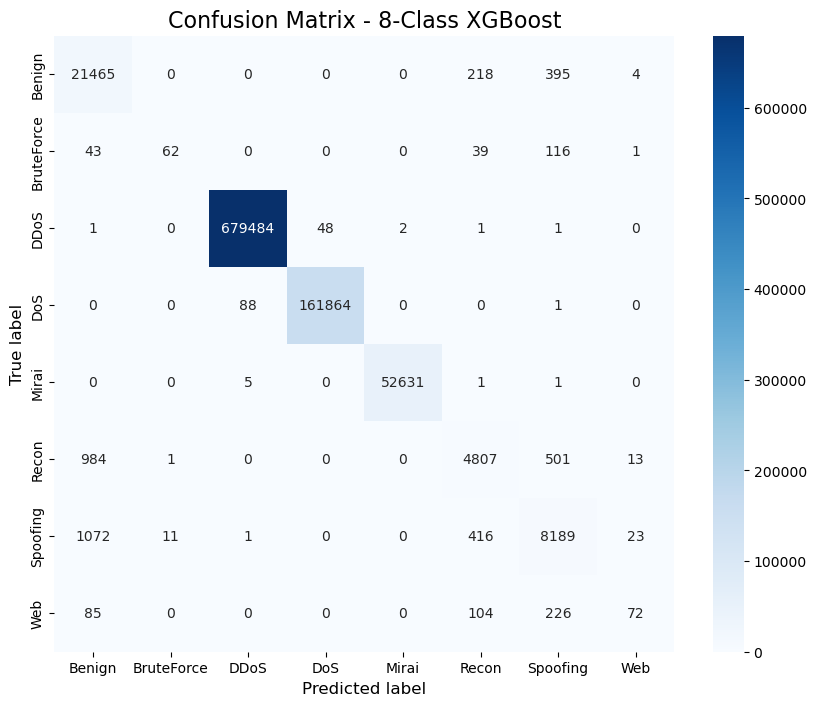

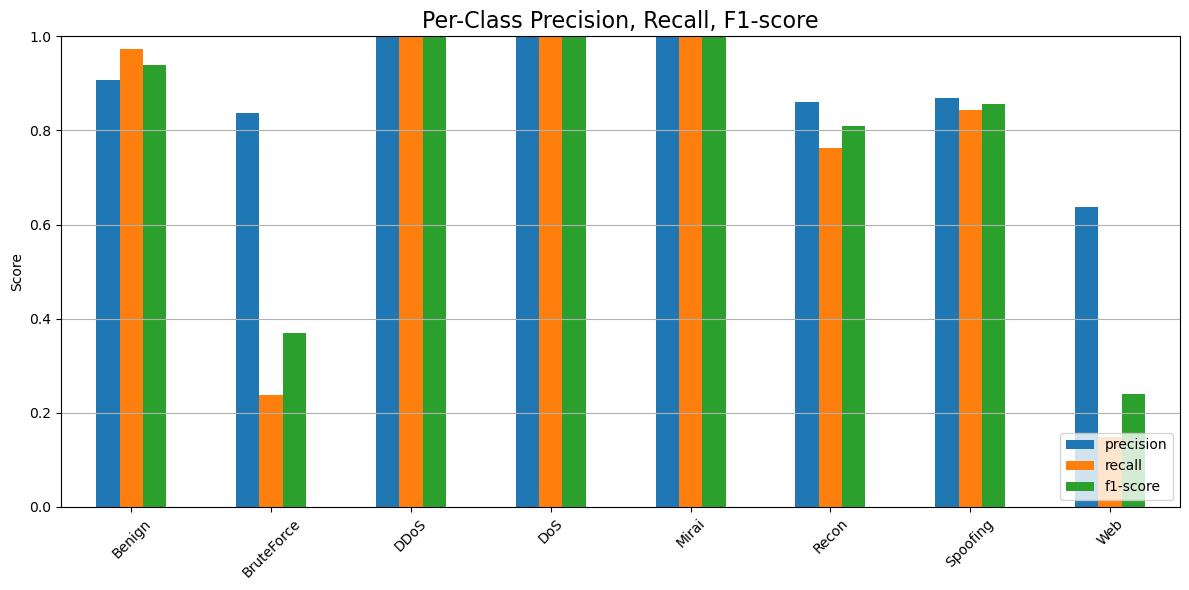

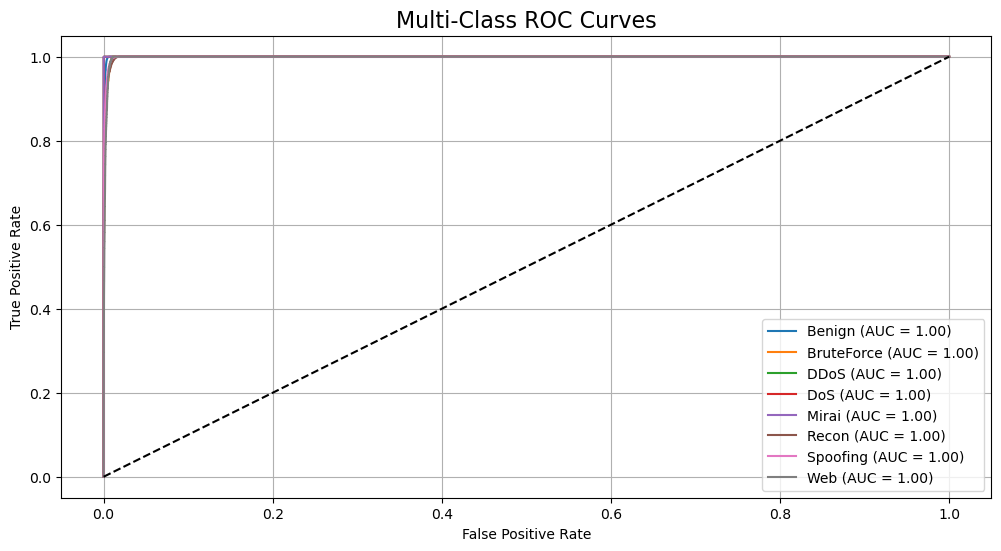

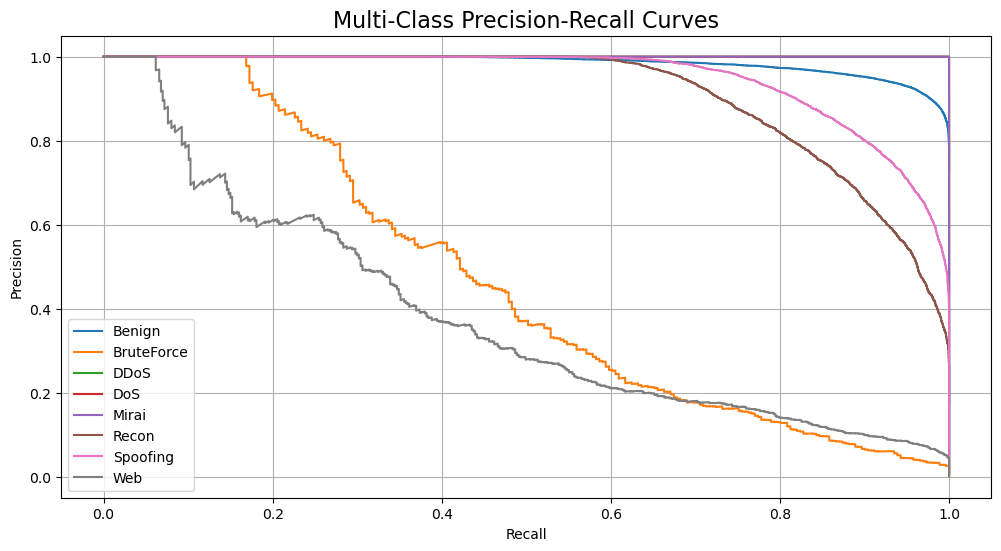


Top 20 important features:
1. IAT: 0.5417
2. Min: 0.1153
3. Weight: 0.0462
4. Number: 0.0299
5. fin_flag_number: 0.0278
6. rst_count: 0.0228
7. urg_count: 0.0197
8. fin_count: 0.0174
9. AVG: 0.0156
10. Magnitue: 0.0147
11. Variance: 0.0137
12. ICMP: 0.0136
13. psh_flag_number: 0.0130
14. syn_flag_number: 0.0118
15. UDP: 0.0114
16. Header_Length: 0.0104
17. TCP: 0.0101
18. Srate: 0.0095
19. Protocol Type: 0.0085
20. SSH: 0.0071


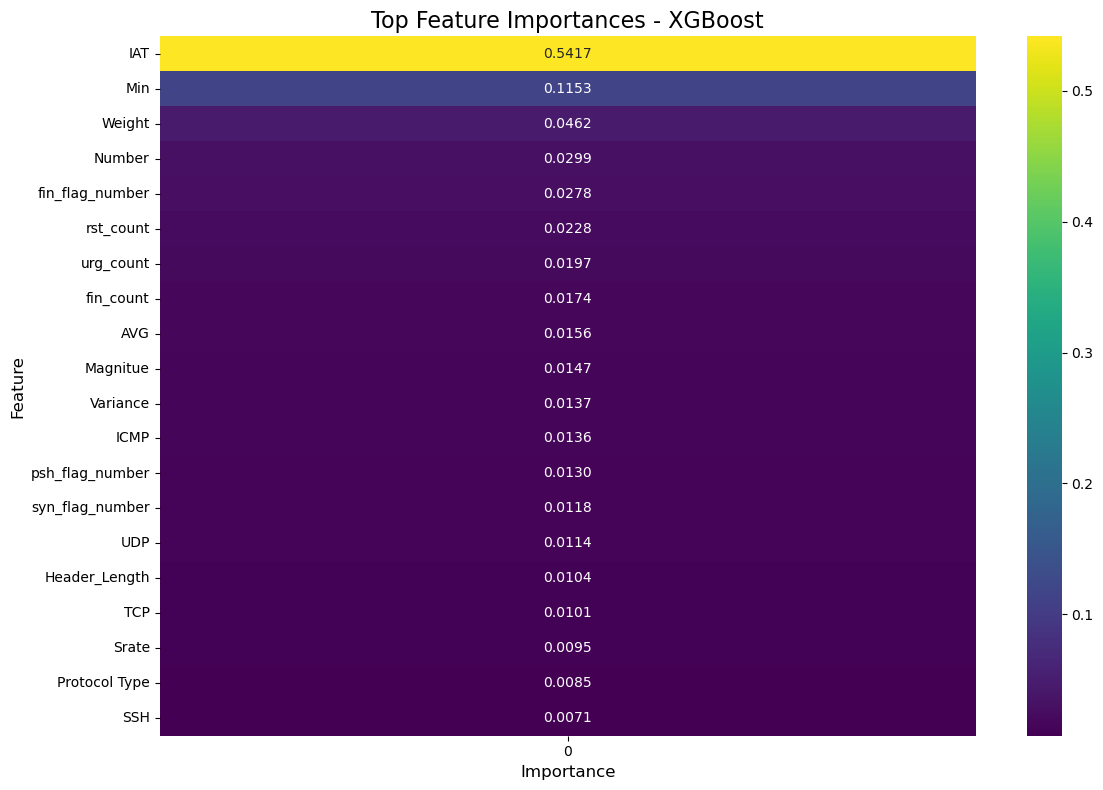

<Figure size 1000x800 with 0 Axes>

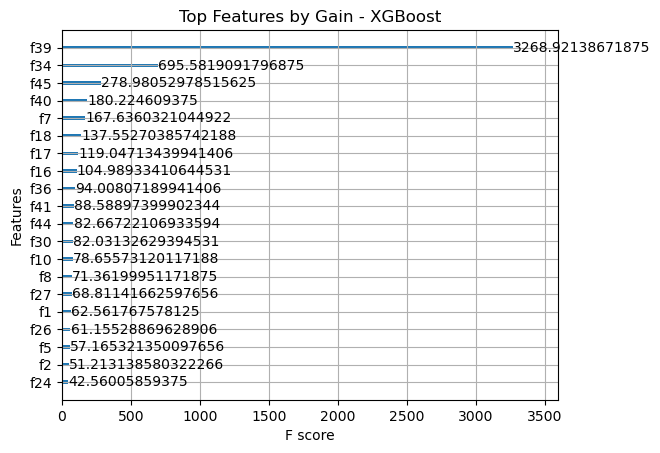



Analysis Complete.


In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import (classification_report, confusion_matrix, f1_score, accuracy_score,
                             recall_score, precision_score, roc_curve, auc, precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, plot_importance

# --- CONFIGURATION ---
RANDOM_STATE = 42
DATASET_PATH = '/Users/bodapati/Downloads/wataiData 3/csv/CICIoT2023'
SAMPLING_FRACTION = 0.1
TOP_N_FEATURES = 20

# --- HELPER FUNCTION FOR PLOTTING ---
def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=16)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.show()

def plot_class_metrics_bar(y_true, y_pred, classes):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    metrics_df = pd.DataFrame(report).transpose().iloc[:-3, :][['precision', 'recall', 'f1-score']]
    metrics_df.plot(kind='bar', figsize=(12, 6))
    plt.title('Per-Class Precision, Recall, F1-score', fontsize=16)
    plt.ylabel('Score')
    plt.xticks(range(len(metrics_df)), classes, rotation=45)
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

def plot_multiclass_roc_pr(y_true, y_score, classes):
    y_bin = label_binarize(y_true, classes=range(len(classes)))
    n_classes = y_bin.shape[1]

    # ROC Curves
    plt.figure(figsize=(12, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('Multi-Class ROC Curves', fontsize=16)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

    # Precision-Recall Curves
    plt.figure(figsize=(12, 6))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
        plt.plot(recall, precision, label=f'{classes[i]}')
    plt.title('Multi-Class Precision-Recall Curves', fontsize=16)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

# --- STEP 1: LOAD & SAMPLE CSVs ---
print("\nStep 1: Loading CSV files with sampling to avoid memory issues...")
all_files = glob.glob(os.path.join(DATASET_PATH, "*.csv"))
if not all_files:
    raise FileNotFoundError(f"No CSV files found in {DATASET_PATH}")
print(f"Found {len(all_files)} CSV files.")

df_list = []
for file in all_files:
    df = pd.read_csv(file).sample(frac=SAMPLING_FRACTION, random_state=RANDOM_STATE)
    df_list.append(df)
main_df = pd.concat(df_list, ignore_index=True)
main_df.dropna(axis=1, how='all', inplace=True)
main_df.dropna(inplace=True)
main_df.drop_duplicates(inplace=True)
print(f"Data loaded. Shape after sampling and cleaning: {main_df.shape}")

# --- STEP 2: 8-CLASS LABEL MAPPING ---
category_map = {
    "BenignTraffic": "Benign",
    "DDoS-ACK_Fragmentation": "DDoS", "DDoS-HTTP_Flood": "DDoS", "DDoS-ICMP_Flood": "DDoS",
    "DDoS-ICMP_Fragmentation": "DDoS", "DDoS-PSHACK_Flood": "DDoS", "DDoS-RSTFINFlood": "DDoS",
    "DDoS-SlowLoris": "DDoS", "DDoS-SYN_Flood": "DDoS", "DDoS-SynonymousIP_Flood": "DDoS",
    "DDoS-TCP_Flood": "DDoS", "DDoS-UDP_Flood": "DDoS", "DDoS-UDP_Fragmentation": "DDoS",
    "DoS-TCP_Flood": "DoS", "DoS-SYN_Flood": "DoS", "DoS-UDP_Flood": "DoS", "DoS-HTTP_Flood": "DoS",
    "Recon-PingSweep": "Recon", "Recon-OSScan": "Recon", "Recon-VulnerabilityScan": "Recon",
    "Recon-PortScan": "Recon", "Recon-HostDiscovery": "Recon",
    "SqlInjection": "Web", "CommandInjection": "Web", "Backdoor_Malware": "Web",
    "Uploading_Attack": "Web", "XSS": "Web", "BrowserHijacking": "Web",
    "DictionaryBruteForce": "BruteForce",
    "MITM-ArpSpoofing": "Spoofing", "DNS_Spoofing": "Spoofing",
    "Mirai-greip_flood": "Mirai", "Mirai-greeth_flood": "Mirai", "Mirai-udpplain": "Mirai"
}
main_df['label'] = main_df['label'].map(category_map)
main_df.dropna(subset=['label'], inplace=True)
print(f"Labels mapped. Unique classes: {main_df['label'].unique()}")

# --- STEP 2.1: PRINT CLASS COUNTS ---
print("\n=== Class Distribution ===")
for label, count in main_df['label'].value_counts().items():
    print(f"{label}: {count}")



# --- STEP 4: TRAIN-TEST SPLIT & FEATURE SCALING ---
cols_to_drop = ['label', 'device', 'device_category', 'ts']
existing_cols_to_drop = [col for col in cols_to_drop if col in main_df.columns]

X = main_df.drop(columns=existing_cols_to_drop).select_dtypes(include=np.number)
y = main_df['label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- STEP 5: TRAIN XGBOOST ---
print("Training XGBoost model...")
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',  # use softprob for ROC/PR curves
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method='hist'
)
xgb_model.fit(X_train_scaled, y_train)

# --- STEP 6: EVALUATION ---
y_pred = np.argmax(xgb_model.predict_proba(X_test_scaled), axis=1)
y_score = xgb_model.predict_proba(X_test_scaled)

print("\n=== 8-Class XGBoost Evaluation ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred, average='macro', zero_division=0))
print("Precision:", precision_score(y_test, y_pred, average='macro', zero_division=0))
print("F1-score :", f1_score(y_test, y_pred, average='macro', zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# --- STEP 7: CONFUSION MATRIX ---
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=le.classes_, title='Confusion Matrix - 8-Class XGBoost')

# --- STEP 8: PER-CLASS METRICS BAR CHART ---
plot_class_metrics_bar(y_test, y_pred, le.classes_)

# --- STEP 9: ROC & PR CURVES ---
plot_multiclass_roc_pr(y_test, y_score, le.classes_)

# --- STEP 10: FEATURE IMPORTANCE ---
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

print("\nTop 20 important features:")
for i in range(min(TOP_N_FEATURES, len(feature_names))):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Bar Heatmap
importance_df = pd.DataFrame([importances], columns=feature_names)
top_features = importance_df.T.sort_values(by=0, ascending=False).head(TOP_N_FEATURES)
plt.figure(figsize=(12, 8))
sns.heatmap(top_features, annot=True, cmap='viridis', fmt=".4f")
plt.title("Top Feature Importances - XGBoost", fontsize=16)
plt.ylabel("Feature", fontsize=12)
plt.xlabel("Importance", fontsize=12)
plt.tight_layout()
plt.show()

# XGBoost Gain Plot
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=TOP_N_FEATURES, importance_type='gain')
plt.title("Top Features by Gain - XGBoost")
plt.show()

print("\n\nAnalysis Complete.")


In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import (classification_report, confusion_matrix, f1_score, accuracy_score,
                             recall_score, precision_score, roc_curve, auc, precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, plot_importance

# --- CONFIGURATION ---
RANDOM_STATE = 42
DATASET_PATH = '/Users/bodapati/Downloads/wataiData 3/csv/CICIoT2023'
SAMPLING_FRACTION = 0.1
TOP_N_FEATURES = 20

# --- HELPER FUNCTION FOR PLOTTING ---
def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=16)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.show()

def plot_class_metrics_bar(y_true, y_pred, classes):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    metrics_df = pd.DataFrame(report).transpose().iloc[:-3, :][['precision', 'recall', 'f1-score']]
    metrics_df.plot(kind='bar', figsize=(12, 6))
    plt.title('Per-Class Precision, Recall, F1-score', fontsize=16)
    plt.ylabel('Score')
    plt.xticks(range(len(metrics_df)), classes, rotation=45)
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

def plot_multiclass_roc_pr(y_true, y_score, classes):
    y_bin = label_binarize(y_true, classes=range(len(classes)))
    n_classes = y_bin.shape[1]

    # ROC Curves
    plt.figure(figsize=(12, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('Multi-Class ROC Curves', fontsize=16)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

    # Precision-Recall Curves
    plt.figure(figsize=(12, 6))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
        plt.plot(recall, precision, label=f'{classes[i]}')
    plt.title('Multi-Class Precision-Recall Curves', fontsize=16)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

# --- STEP 1: LOAD & SAMPLE CSVs ---
print("\nStep 1: Loading CSV files with sampling to avoid memory issues...")
all_files = glob.glob(os.path.join(DATASET_PATH, "*.csv"))
if not all_files:
    raise FileNotFoundError(f"No CSV files found in {DATASET_PATH}")
print(f"Found {len(all_files)} CSV files.")

df_list = []
for file in all_files:
    df = pd.read_csv(file).sample(frac=SAMPLING_FRACTION, random_state=RANDOM_STATE)
    df_list.append(df)
main_df = pd.concat(df_list, ignore_index=True)
main_df.dropna(axis=1, how='all', inplace=True)
main_df.dropna(inplace=True)
main_df.drop_duplicates(inplace=True)
print(f"Data loaded. Shape after sampling and cleaning: {main_df.shape}")

# --- STEP 2: 8-CLASS LABEL MAPPING ---
category_map = {
    "BenignTraffic": "Benign",
    "DDoS-ACK_Fragmentation": "DDoS", "DDoS-HTTP_Flood": "DDoS", "DDoS-ICMP_Flood": "DDoS",
    "DDoS-ICMP_Fragmentation": "DDoS", "DDoS-PSHACK_Flood": "DDoS", "DDoS-RSTFINFlood": "DDoS",
    "DDoS-SlowLoris": "DDoS", "DDoS-SYN_Flood": "DDoS", "DDoS-SynonymousIP_Flood": "DDoS",
    "DDoS-TCP_Flood": "DDoS", "DDoS-UDP_Flood": "DDoS", "DDoS-UDP_Fragmentation": "DDoS",
    "DoS-TCP_Flood": "DoS", "DoS-SYN_Flood": "DoS", "DoS-UDP_Flood": "DoS", "DoS-HTTP_Flood": "DoS",
    "Recon-PingSweep": "Recon", "Recon-OSScan": "Recon", "Recon-VulnerabilityScan": "Recon",
    "Recon-PortScan": "Recon", "Recon-HostDiscovery": "Recon",
    "SqlInjection": "Web", "CommandInjection": "Web", "Backdoor_Malware": "Web",
    "Uploading_Attack": "Web", "XSS": "Web", "BrowserHijacking": "Web",
    "DictionaryBruteForce": "BruteForce",
    "MITM-ArpSpoofing": "Spoofing", "DNS_Spoofing": "Spoofing",
    "Mirai-greip_flood": "Mirai", "Mirai-greeth_flood": "Mirai", "Mirai-udpplain": "Mirai"
}
main_df['label'] = main_df['label'].map(category_map)
main_df.dropna(subset=['label'], inplace=True)
print(f"Labels mapped. Unique classes: {main_df['label'].unique()}")

# --- STEP 2.1: PRINT CLASS COUNTS ---
print("\n=== Class Distribution ===")
for label, count in main_df['label'].value_counts().items():
    print(f"{label}: {count}")



# --- STEP 4: TRAIN-TEST SPLIT & FEATURE SCALING ---
cols_to_drop = ['label', 'device', 'device_category', 'ts']
existing_cols_to_drop = [col for col in cols_to_drop if col in main_df.columns]

X = main_df.drop(columns=existing_cols_to_drop).select_dtypes(include=np.number)
y = main_df['label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- STEP 5: TRAIN XGBOOST WITH EVAL SET ---
print("Training XGBoost model...")

xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=len(le.classes_),
    eval_metric=['mlogloss', 'merror'],
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method='hist'
)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)]
xgb_model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)

# --- STEP 6: EVALUATION ---
y_pred = np.argmax(xgb_model.predict_proba(X_test_scaled), axis=1)
y_score = xgb_model.predict_proba(X_test_scaled)

print("\n=== 8-Class XGBoost Evaluation ===")
print("Train Accuracy:", accuracy_score(y_train, np.argmax(xgb_model.predict_proba(X_train_scaled), axis=1)))
print("Test Accuracy :", accuracy_score(y_test, y_pred))
print("Test Recall   :", recall_score(y_test, y_pred, average='macro', zero_division=0))
print("Test Precision:", precision_score(y_test, y_pred, average='macro', zero_division=0))
print("Test F1-score :", f1_score(y_test, y_pred, average='macro', zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# --- STEP 6.1: TRAIN/TEST LOSS & ACCURACY PLOTS ---
results = xgb_model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Plot log loss
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train Loss')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Test Loss')
plt.title('XGBoost Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()
plt.grid()
plt.show()

# Plot accuracy (1 - error)
plt.figure(figsize=(10, 6))
plt.plot(x_axis, [1 - e for e in results['validation_0']['merror']], label='Train Accuracy')
plt.plot(x_axis, [1 - e for e in results['validation_1']['merror']], label='Test Accuracy')
plt.title('XGBoost Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# --- STEP 7: CONFUSION MATRIX ---
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=le.classes_, title='Confusion Matrix - 8-Class XGBoost')

# --- STEP 8: PER-CLASS METRICS BAR CHART ---
plot_class_metrics_bar(y_test, y_pred, le.classes_)

# --- STEP 9: ROC & PR CURVES ---
plot_multiclass_roc_pr(y_test, y_score, le.classes_)

# --- STEP 10: FEATURE IMPORTANCE ---
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

print("\nTop 20 important features:")
for i in range(min(TOP_N_FEATURES, len(feature_names))):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Bar Heatmap
importance_df = pd.DataFrame([importances], columns=feature_names)
top_features = importance_df.T.sort_values(by=0, ascending=False).head(TOP_N_FEATURES)
plt.figure(figsize=(12, 8))
sns.heatmap(top_features, annot=True, cmap='viridis', fmt=".4f")
plt.title("Top Feature Importances - XGBoost", fontsize=16)
plt.ylabel("Feature", fontsize=12)
plt.xlabel("Importance", fontsize=12)
plt.tight_layout()
plt.show()

# XGBoost Gain Plot
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=TOP_N_FEATURES, importance_type='gain')
plt.title("Top Features by Gain - XGBoost")
plt.show()

print("\n\nAnalysis Complete.")


Step 1: Loading CSV files with sampling to avoid memory issues...
Found 169 CSV files.
